# SIwave DC-IR Analysis

This example demonstrates the use of EDB to interact with a PCB
layout and run DC-IR analysis in SIwave.

## Perform imports

Perform required imports.

In [1]:
import os
import tempfile
import time

import pyedb
from pyedb.misc.downloads import download_file

In [2]:
temp_dir = tempfile.TemporaryDirectory(suffix=".ansys")
targetfile = download_file("edb/ANSYS-HSD_V1.aedb", destination=temp_dir.name)

siwave_file = os.path.join(os.path.dirname(targetfile), "ANSYS-HSD_V1.siw")
print(targetfile)
aedt_file = targetfile[:-4] + "aedt"

C:\Users\ansys\AppData\Local\Temp\tmpxp1c3zte.ansys\edb/ANSYS-HSD_V1.aedb


## Launch Ansys Electronics Database (EDB)

Instantiate an instance of the `pyedb.Edb` class using SI units.

In [3]:
if os.path.exists(aedt_file):
    os.remove(aedt_file)

# Select EDB version (change it manually if needed, e.g. "2025.1")
edb_version = "2025.2"
print(f"EDB version: {edb_version}")

edb = pyedb.Edb(edbpath=targetfile, edbversion=edb_version)

EDB version: 2025.2


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `edbversion` is deprecated for method `Edb`; use `version` instead.
  warnings.warn(
C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyEDB INFO: Star initializing Edb 10:25:18.895906


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database ANSYS-HSD_V1.aedb Opened in 2025.2


PyEDB INFO: Cell main Opened


PyEDB INFO: Builder was initialized.


PyEDB INFO: open_edb completed in 9.0401 seconds.


PyEDB INFO: EDB initialization completed in 9.1034 seconds.


## Identify nets and components

The ``Edb.nets.netlist`` and ``Edb.components.instances`` properties contain information
about all of the nets and components. The following cell uses this information to print the
number of nets and components.

In [4]:
print("Nets {}".format(len(edb.nets.netlist)))
start = time.time()
print("Components {}".format(len(edb.components.instances.keys())))
print("elapsed time = ", time.time() - start)

Nets 348
Components 509
elapsed time =  0.0


## Identify pin positions

This code shows how to obtain all pins for a specific component and
print the ``[x, y]`` position of each pin.

In [5]:
pins = edb.components["U2"].pins
count = 0
for pin in edb.components["U2"].pins.values():
    if count < 10:  # Only print the first 10 pin coordinates.
        print(pin.position)
    elif count == 10:
        print("...and many more.")
    else:
        pass
    count += 1

[0.1315, 0.019]
[0.131, 0.019]
[0.1305, 0.019]
[0.13, 0.019]
[0.1295, 0.019]
[0.129, 0.019]
[0.1285, 0.019]
[0.128, 0.019]
[0.1275, 0.019]
[0.127, 0.019]
...and many more.


Get all nets connected to a specific component. Print
the pin and the name of the net that it is connected to.

In [6]:
connections = edb.components.get_component_net_connection_info("U2")
n_print = 0  # Counter to limit the number of printed lines.
print_max = 15
for m in range(len(connections["pin_name"])):
    ref_des = connections["refdes"][m]
    pin_name = connections["pin_name"][m]
    net_name = connections["net_name"][m]
    if net_name != "" and (n_print < print_max):
        print('{}, pin {} -> net "{}"'.format(ref_des, pin_name, net_name))
        n_print += 1
    elif n_print == print_max:
        print("...and many more.")
        n_print += 1

U2, pin 20 -> net "1V0"
U2, pin 21 -> net "1V0"
U2, pin 22 -> net "1V0"
U2, pin 23 -> net "1V0"
U2, pin 24 -> net "1V0"
U2, pin 25 -> net "1V0"
U2, pin 26 -> net "1V0"
U2, pin 27 -> net "1V0"
U2, pin 28 -> net "1V0"
U2, pin 32 -> net "GND"
U2, pin 33 -> net "GND"
U2, pin 34 -> net "GND"
U2, pin 35 -> net "GND"
U2, pin 36 -> net "GND"
U2, pin 37 -> net "GND"
...and many more.


Compute rats.

In [7]:
rats = edb.components.get_rats()

## Identify connected nets

The ``get_dcconnected_net_list()`` method retrieves a list of
all DC-connected power nets. Each group of connected nets is returned
as a [set](https://docs.python.org/3/tutorial/datastructures.html#sets).
The first argument to the method is the list of ground nets, which are
not considered in the search for connected nets.

In [8]:
GROUND_NETS = ["GND", "GND_DP"]
dc_connected_net_list = edb.nets.get_dcconnected_net_list(GROUND_NETS)
for pnets in dc_connected_net_list:
    print(pnets)

{'NetD3_2', 'AVCC_1V3'}
{'2V5', 'NetC271_1', '1.8V_DVDDH'}
{'1.2V_AVDLL_PLL', '1.2V_AVDDL', '1.2V_DVDDL'}
{'5V', 'NetIC1_8', 'SFPA_VCCR', 'PDEN', 'SFPA_VCCT', 'USB3_VBUS', '3.3V_AVDDH'}
{'VDD_DDR', 'NetR22_1'}
{'1V0', 'NetR8_1'}


## Power Tree

The power tree provides connectivity through all components from the VRM to
the device.

In [9]:
VRM = "U1"
OUTPUT_NET = "AVCC_1V3"
powertree_df, component_list_columns, net_group = edb.nets.get_powertree(OUTPUT_NET, GROUND_NETS)

Print some information about the power tree.

In [10]:
print_columns = ["refdes", "pin_name", "component_partname"]
ncol = [component_list_columns.index(c) for c in print_columns]

This prints the header. Replace "pin_name" with "pin" to
make the header align with the values.

In [11]:
print("\t".join(print_columns).replace("pin_name", "pin"))

for el in powertree_df:
    s = ""
    count = 0
    for e in el:
        if count in ncol:
            s += "{}\t".format(e)
        count += 1
    s.rstrip()
    print(s)

refdes	pin	component_partname
L10	1	WE-Coil-PD4-S	
IC2	1	SOIC127P-680x175-8_N	
D3	2	DO214AA	
R1	1	RESC1608X05N	
L10	2	WE-Coil-PD4-S	
C46	1	CAPMP7343X31N	
C53	2	CAPC1005X33X10LL5	
C68	2	CAPC1005X33X10LL5	
C52	2	CAPC1005X33X10LL5	
C45	1	CAPC1608X08N	
C55	2	CAPC1005X33X10LL5	
C58	2	CAPC1005X33X10LL5	
C54	2	CAPC1005X33X10LL5	
C60	2	CAPC1005X33X10LL5	
C57	2	CAPC1005X33X10LL5	
C73	2	CAPC1005X33X10LL5	
C69	2	CAPC1005X33X10LL5	
C56	2	CAPC1005X33X10LL5	
C205	2	CAPC1005X33X10LL5	
C238	2	CAPC1005X33X10LL5	
C145	2	CAPC0603X33X15LL03T05	
C144	2	CAPC0603X33X15LL03T05	
C143	2	CAPC0603X33X15LL03T05	
C142	2	CAPC0603X33X15LL03T05	
C141	2	CAPC0603X33X15LL03T05	
C140	2	CAPC0603X33X15LL03T05	
C139	2	CAPC0603X33X15LL03T05	
C138	2	CAPC0603X33X15LL03T05	
C137	2	CAPC0603X33X15LL03T05	
C136	2	CAPC0603X33X15LL03T05	
C135	2	CAPC0603X33X15LL03T05	
C134	2	CAPC0603X33X15LL03T05	
C133	2	CAPC0603X33X15LL03T05	
C132	2	CAPC0603X33X15LL03T05	
C131	2	CAPC0603X33X15LL03T05	
C130	2	CAPC0603X33X15LL03T05	
C129	2	CAPC0603X33X

## Remove unused components

Delete all RLC components that are connected with only one pin.
The ``Edb.components.delete_single_pin_rlc()`` method
provides a useful way to
remove components that are not needed for the simulation.

In [12]:
edb.components.delete_single_pin_rlc()

PyEDB INFO: Deleted 0 components


[]

You can also remove unused components explicitly by name.

In [13]:
edb.components.delete("C380")

True

Nets can also be removed explicitly.

In [14]:
edb.nets.delete("PDEN")

['PDEN']

Print the top and bottom elevation of the stackup obtained using
the ``Edb.stackup.limits()`` method.

In [15]:
s = 'Top layer name: "{top}", Elevation: {top_el:.2f} '
s += 'mm\nBottom layer name: "{bot}", Elevation: {bot_el:2f} mm'
top, top_el, bot, bot_el = edb.stackup.limits()
print(s.format(top=top, top_el=top_el * 1e3, bot=bot, bot_el=bot_el * 1e3))

Top layer name: "1_Top", Elevation: 1.75 mm
Bottom layer name: "16_Bottom", Elevation: 0.000000 mm


## Set up for SIwave DCIR analysis

Create a voltage source and then set up a DCIR analysis.

In [16]:
edb.siwave.create_voltage_source_on_net("U1", "AVCC_1V3", "U1", "GND", 1.3, 0, "V1")
edb.siwave.create_current_source_on_net("IC2", "NetD3_2", "IC2", "GND", 1.0, 0, "I1")
setup = edb.siwave.add_siwave_dc_analysis("myDCIR_4")
setup.use_dc_custom_settings = True
setup.set_dc_slider = 0
setup.add_source_terminal_to_ground("V1", 1)

True

## Solve

Save the modifications and run the analysis in SIwave.

PyEDB INFO: Save Edb file completed in 0.1154 seconds.


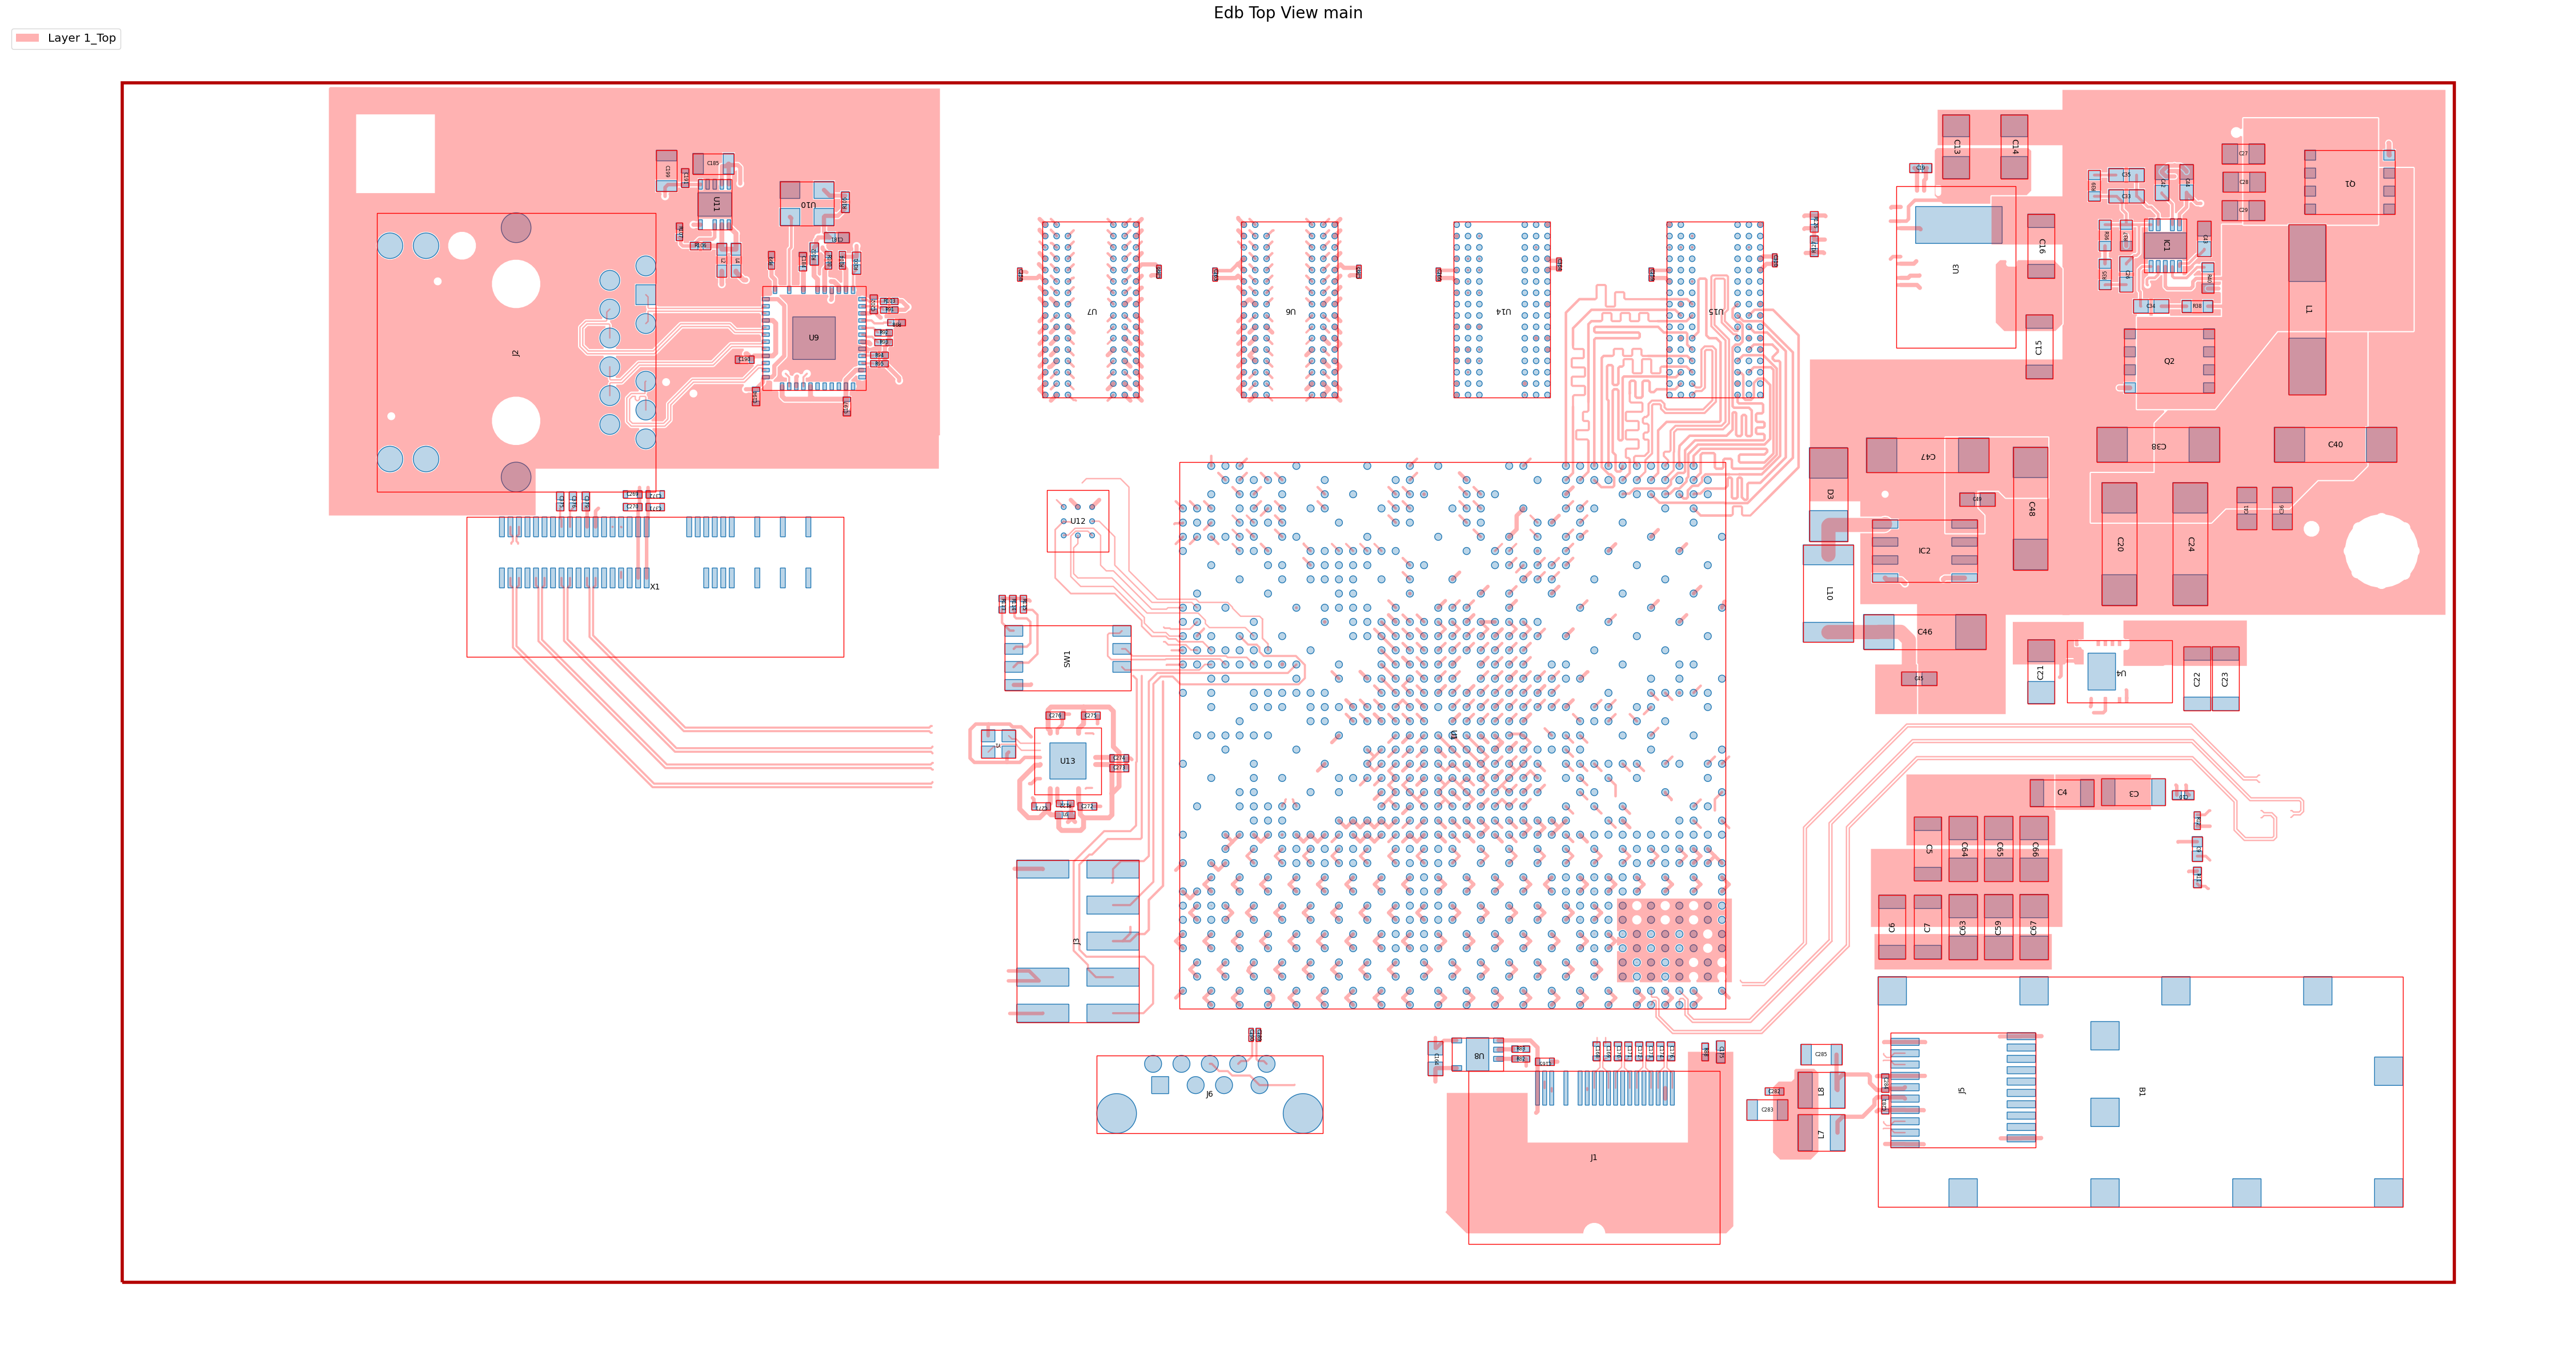

PyEDB INFO: Plot Generation time 11.0


(<Figure size 6000x3000 with 1 Axes>,
 <Axes: title={'center': 'Edb Top View main'}>)

In [17]:
edb.save_edb()
edb.nets.plot(None, "1_Top", plot_components_on_top=True)

## Export results

Export all quantities calculated from the DC-IR analysis.
The following method runs SIwave in batch mode from the command line.
Results are written to the edb folder.
Un-commment following lines to analyze with SIwave and export results.

siw_file = edb.solve_siwave()
outputs = edb.export_siwave_dc_results(
    siw_file,
    setup.name,
)

Close EDB. After EDB is closed, it can be opened by AEDT.

In [18]:
edb.close_edb()

PyEDB INFO: Close Edb file completed in 0.1532 seconds.


True

## View Layout in SIwave

The SIwave user interface can be visualized and manipulated
using the SIwave user interface. This command works on Window OS only.

In [19]:
# siwave = pyedb.Siwave("2025.1")
# siwave.open_project(siwave_file)
# report_file = os.path.join(temp_folder,'Ansys.htm')

# siwave.export_siwave_report("myDCIR_4", report_file)
# siwave.close_project()
# siwave.quit_application()

Clean up the temporary files and directory.

In [20]:
temp_dir.cleanup()